# CIFAR-10 data loader functions

In [1]:
import os
import subprocess
from urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image

In [2]:
curr_dir = os.getcwd()

In [3]:
######################################################################
# Setup working directory
######################################################################
os.chdir(curr_dir)
data_dir = os.path.join(curr_dir, 'data/')

if not os.path.exists(data_dir):
    subprocess.run(['mkdir', data_dir])

os.chdir(data_dir)

In [4]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto'):

    if untar:
        untar_fpath = os.path.join(data_dir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(data_dir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, data_dir, archive_format)

    return fpath

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

# Load data

In [5]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
# Download CIFAR dataset
m = load_cifar10()

File path: /Users/abew/Documents/ML-practice/colorize-images/data/colours.tar.gz
File path: /Users/abew/Documents/ML-practice/colorize-images/data/cifar-10-batches-py.tar.gz


# Colourization as Classification

Select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 

The cluster centers are provided in http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz, and downloaded by the helper functions above. For simplicity, though it is not ideal, measure distance in RGB space.

In [6]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import time

import numpy as np
import numpy.random as npr
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


#from load_data import load_cifar10

CIFAR_10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

lookup_dict = {label:i for i, label in enumerate(CIFAR_10_LABELS)}

CATEGORY = lookup_dict['horse']

In [7]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values.
    Args:
      xs: float numpy array of RGB images in [B, H, W, C] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, H, W, 1]
    """

    def helper(xs, colours):
        """
        Get colour categories given RGB values. This is done by choosing
        the colour in `colours` that is the closest (in RGB space) to
        each point in the image `xs`. This function is a little memory
        intensive, and so the size of `xs` should not be too large.

        Args:
          xs: float numpy array of RGB images in [B, H, W, C] format
          colours: numpy array of colour categories and their RGB values
        Returns:
          result: int numpy array of shape [B, H, W, 1]
        """
        num_colours = np.shape(colours)[0]
        xs = np.expand_dims(xs, 0)
        cs = np.reshape(colours, [num_colours,1,1,1,3])
        dists = np.linalg.norm(xs-cs, axis=-1) # -1 = colour axis
        cat = np.argmin(dists, axis=0)
        cat = np.expand_dims(cat, axis=-1)
        return cat
    
    # limit the batch_size to max of 100
    if np.shape(xs)[0] < 100:
        return helper(xs)
    
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next_val = helper(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next_val)
    result = np.concatenate(nexts, axis=0)
    return result

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the specified category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    xs = np.transpose(xs, [0,2,3,1])
    
    grey = np.mean(xs, axis=-1, keepdims=True)

    if downsize_input:
        downsize_module = keras.Sequential(
            layers = [layers.AveragePooling2D(2),
                      layers.AveragePooling2D(2),
                      layers.UpSampling2D(2),
                      layers.UpSampling2D(2)
                     ]
        )
        xs_downsized = downsize_module(
            tf.convert_to_tensor(xs))
        xs_downsized = xs_downsized.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

# Build model

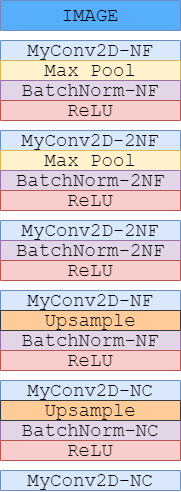

In [8]:
def conv_block(image, kernel_size, num_filters, 
               pool=True, batch_norm=True, upsample=False):
    
    x = layers.Conv2D(filters=num_filters,
                      kernel_size=kernel_size,
                      padding='SAME')(image)
    if pool:
        x = layers.MaxPool2D(pool_size=(2,2))(x)
    elif upsample:
        x = layers.UpSampling2D(size=(2,2))(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    
    return layers.Activation('relu')(x)

def custom_loss(y_true, y_pred):
    predicted = tf.reshape(y_pred,[-1,y_pred.shape[-1]])
    ground_truth = tf.reshape(y_true,[-1,y_true.shape[-1]])
    
    return keras.losses.SparseCategoricalCrossentropy(from_logits=True)(
        ground_truth, predicted)

In [9]:
def colorizer_model(input_shape, kernel_size, num_filters, num_colors,
                   optimizer='adam', loss=custom_loss, lr=None):
    
    image_in = layers.Input(shape=input_shape)
    
    x = conv_block(image_in, kernel_size, num_filters)
    x = conv_block(x, kernel_size, 2*num_filters)
    x = conv_block(x, kernel_size, 2*num_filters, pool=False)
    x = conv_block(x, kernel_size, num_filters, pool=False, upsample=True)
    x = conv_block(x, kernel_size, num_colors, pool=False, upsample=True)
    
    outputs = layers.Conv2D(filters=num_colors, 
                            kernel_size=kernel_size,
                            padding='SAME')(x)
    
    model = keras.Model(inputs=image_in, outputs=outputs)
    
    optimizer = keras.optimizers.get(optimizer)
    if lr is not None:
        optimizer.lr = lr
        
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = [loss,
                   keras.losses.mse]
    )
    
    return model

In [12]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def train(args, cnn=None):
    # Numpy random seed
    npr.seed(args.seed)

    # select save directory
    save_dir = os.path.join(curr_dir,"outputs",args.experiment_name)

    # LOAD THE COLOURS CATEGORIES 'ASCII', 'latin1', or 'bytes'
    colours = np.load(args.colours, allow_pickle=True, encoding='bytes')[0]
    num_colours = np.shape(colours)[0]
    
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3

    # LOAD THE MODEL
    cnn = colorizer_model(
        args.img_size+[num_in_channels],
        args.kernel, 
        args.num_filters, 
        num_colours,
        optimizer = args.optimizer,
        loss = args.loss,
        lr = args.learn_rate
    )
    
    # show the model summary
    cnn.summary()
    
    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir) 
    
    print(train_grey.shape)
    print(train_rgb.shape)
    print(train_rgb_cat.shape)
    
    print("Beginning training ...")    
    board_params = keras.callbacks.TensorBoard(log_dir=os.path.join(curr_dir,'logs'),
                                                histogram_freq=5, 
                                                write_images=True,
                                                )
    model_saver = keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'checkpoint'),
                                               monitor='val_loss',
                                               mode='min',
                                               save_best_only=True,
                                                 )
    callbacks = [model_saver, board_params]
    
    history = cnn.fit(x = train_grey,
                        y = train_rgb_cat,
                        epochs = args.epochs,
                        callbacks = callbacks,
                        validation_split = 0.2,
                        shuffle = False,
                        workers = 1,
                        use_multiprocessing = False,
                        verbose=1
                       )
    
    test_losses = cnn.evaluate(x = test_grey, y = test_rgb_cat)

    return history, test_loss, test_metric, cnn


In [13]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours': data_dir + '/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'img_size':[32,32],
              'num_filters':32,
              'optimizer':'adam',
              'loss': custom_loss,
              'learn_rate':0.3, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
hist, test_loss, test_metric, model= train(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0   

2022-01-02 20:59:13.328730: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-02 20:59:13.328770: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-02 20:59:13.329018: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  2/125 [..............................] - ETA: 26s - loss: 5.9725 - custom_loss: 5.9725 - mean_squared_error: 247.2238 

2022-01-02 20:59:14.847360: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-02 20:59:14.847388: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  3/125 [..............................] - ETA: 31s - loss: 5.4853 - custom_loss: 5.4853 - mean_squared_error: 242.7921

2022-01-02 20:59:15.129194: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-02 20:59:15.132210: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-02 20:59:15.135318: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/abew/Documents/ML-practice/colorize-images/logs/train/plugins/profile/2022_01_02_20_59_15

2022-01-02 20:59:15.137812: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/abew/Documents/ML-practice/colorize-images/logs/train/plugins/profile/2022_01_02_20_59_15/Abe.local.trace.json.gz
2022-01-02 20:59:15.142834: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/abew/Documents/ML-practice/colorize-images/logs/train/plugins/profile/2022_01_02_20_59_15

2022-01-02 20:59:15.143424: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool 

125/125 [==============================] - 25s 193ms/step - loss: 2.8855 - custom_loss: 2.8855 - mean_squared_error: 194.8664 - val_loss: 5.5749 - val_custom_loss: 5.5591 - val_mean_squared_error: 475.6033
INFO:tensorflow:Assets written to: /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint/assets
Epoch 2/25
125/125 [==============================] - 25s 204ms/step - loss: 2.4258 - custom_loss: 2.4258 - mean_squared_error: 195.5440 - val_loss: 3.2115 - val_custom_loss: 3.2033 - val_mean_squared_error: 254.8774
INFO:tensorflow:Assets written to: /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint/assets
Epoch 3/25
125/125 [==============================] - 23s 182ms/step - loss: 2.3020 - custom_loss: 2.3020 - mean_squared_error: 206.9175 - val_loss: 3.0457 - val_custom_loss: 3.0434 - val_mean_squared_error: 322.4783
INFO:tensorflow:Assets written to: /Users/abew/Documents/ML-practice/colorize-images/outputs/colouriza

ValueError: too many values to unpack (expected 2)

In [15]:
final_model = colorizer_model(
        args.img_size+[1],
        args.kernel, 
        args.num_filters, 
        24,
        optimizer = args.optimizer,
        loss = args.loss,
        lr = args.learn_rate
    )

In [16]:
final_model.load_weights(os.path.join(curr_dir,"outputs",args.experiment_name, 'checkpoint'))

2022-01-02 21:28:08.249225: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint: Failed precondition: /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [24]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

colours = np.load(args.colours, allow_pickle=True, encoding='bytes')[0]

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
train_rgb_cat = get_rgb_cat(train_rgb, colours)
test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
test_rgb_cat = get_rgb_cat(test_rgb, colours)

print("completed")

Loading data...
File path: /Users/abew/Documents/ML-practice/colorize-images/data/cifar-10-batches-py.tar.gz
Transforming data...
completed


In [26]:
train_losses = final_model.evaluate(x = train_grey, y = train_rgb_cat)
test_losses = final_model.evaluate(x = test_grey, y = test_rgb_cat)

32/32 [==============================] - 2s 63ms/step - loss: 2.0045 - custom_loss: 2.0001 - mean_squared_error: 552.5429


In [27]:
print(train_losses)
print(test_losses)

[2.0026402473449707, 2.002565622329712, 552.508056640625]
[2.0045478343963623, 2.0000598430633545, 552.5429077148438]


In [62]:
sample_test = test_grey[:10]

pred = final_model.predict(sample_test).mean(axis=-1).astype('int')

pred[pred<=1] = 1

pred[pred>=24] = 23

print(colours.shape)
pred_color = get_cat_rgb(pred[:10], colours)

(24, 3)


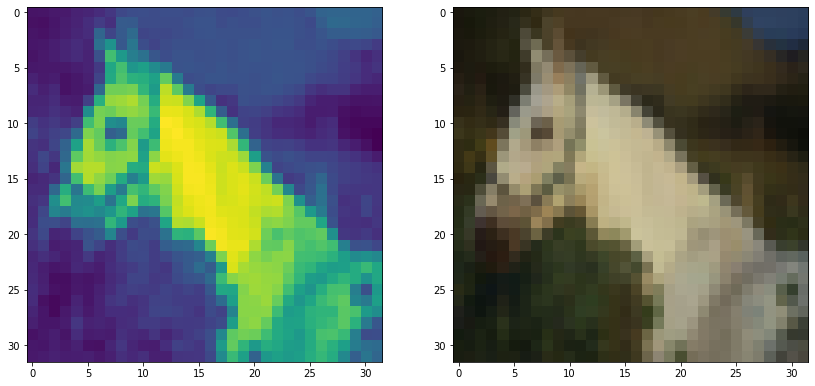

In [64]:
fig,ax = plt.subplots(ncols=2, figsize=(14,8))

# ax[0].imshow(pred[0].mean(axis=-1))
ax[0].imshow(sample_test[0])
ax[1].imshow(test_rgb[0])

plt.show()

In [67]:
print(sample_test[0,...,0])

[[0.0859375  0.08984375 0.09635417 ... 0.26953125 0.26822917 0.26041667]
 [0.08203125 0.07942708 0.09244792 ... 0.27213542 0.26822917 0.25651042]
 [0.08854167 0.08333333 0.09505208 ... 0.25260417 0.25130208 0.23958333]
 ...
 [0.08463542 0.09505208 0.10807292 ... 0.33984375 0.20833333 0.20963542]
 [0.09505208 0.09114583 0.10807292 ... 0.33463542 0.29557292 0.28776042]
 [0.09635417 0.10286458 0.11328125 ... 0.25520833 0.31380208 0.2734375 ]]
